In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# Loan default factors analysis

by: Moiez Ismail

#### Table of Contents:
- [Introduction](#Introduction)
- [Data overview](#Data-overview)
- [Data cleaning and processing](#Data-cleaning-and-preprocessing)
- [Analysis](#Analysis)
- [Insights and conclusion](#Insights-and-conclusions)

# Introduction
A ficticious bank, Global Bank (GB) derives profit from interest on loans but faces risks when clients default on their loans (DL hereafter). Defaulting refers to when a loan is not properly paid off in full(GL hereafter), either with missed payments(delinquency) or no payments at all. The approval process is crucial to minimize DLs and maximize GLs.
## Objective
- GB is conducting a data analysis in order to gain insights in order to assist in the loan approval process. 
## Key Questions
- What factors or category of factors are most indicative of a client's likelihood to default? 
- Is there a statistically significant difference in certain numerica/categorical features between GL and DL? 
## Executive Summary
- there is notable correlation between loan defaults and credit-related factors such as the numer of derogatory reports and delinquent credit lines as opposed to financial metrics like loan amount and property value do not show a strong correlation with default rates.
- There was almost no difference in loan amount between godo status and defaulting loans. 
- Recommendations to GB include: 1) acquire a more granular dataset that includes a broader range of job categories and more specific reasons for loans. If permissible by law, data pertaining to income could yield additional insights, especially since the Debt-to-Income (DTI) ratio was indicative while the total income was not disclosed.
-The inclusion of time-stamped credit scores could also enhance the predictive power of the analysis regarding default risks.

### Data dictionary
| Variable  | Data Type     | Description                                                                                               |
|-----------|---------------|-----------------------------------------------------------------------------------------------------------|
| BAD       | Binary (1/0)  | 1 = Client defaulted on loan, 0 = loan repaid                                                            |
| LOAN      | Numeric       | Amount of loan approved.                                                                                  |
| MORTDUE   | Numeric       | Amount due on the existing mortgage.                                                                      |
| VALUE     | Numeric       | Current value of the property.                                                                           |
| REASON    | Categorical   | Reason for the loan request. (HomeImp = home improvement, DebtCon = debt consolidation)                   |
| JOB       | Categorical   | Job category：office, manager, self, professional executive, and Sales.                                      |
| YOJ       | Numeric       | Years at present job.                                                                                    |
| DEROG     | Numeric       | Number of major derogatory reports (indicating serious delinquency or late payments).                     |
| DELINQ    | Numeric       | Number of delinquent credit lines (a line of credit becomes delinquent when payments are overdue).        |
| CLAGE     | Numeric       | Age of the oldest credit line in months.                                                                 |
| NINQ      | Numeric       | Number of recent credit inquiries.                                                                        |
| CLNO      | Numeric       | Number of existing credit lines.                                                                          |
| DEBTINC   | Numeric       | Debt-to-income ratio (monthly debt payments divided by gross monthly income, a measure of repayment ability). |

## **Import the necessary libraries and data**

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"
import pandas as pd
import uuid
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
#statistics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, pearsonr, normaltest, ttest_ind, f_oneway, chisquare, chi2_contingency, shapiro

## Data overview
1. understanding the shape of data, data types and missing values
2. checking for duplicated values
3. having a look at the summary statistics of the numerical columns

In [4]:
data = pd.read_csv('/Users/moiezismail/projects/loan/raw_loan_data.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
# Code to find out the % of missing values for each column 
np.round(data.isnull().sum() / len(data.isnull()) * 100)

BAD         0.0
LOAN        0.0
MORTDUE     9.0
VALUE       2.0
REASON      4.0
JOB         5.0
YOJ         9.0
DEROG      12.0
DELINQ     10.0
CLAGE       5.0
NINQ        9.0
CLNO        4.0
DEBTINC    21.0
dtype: float64

In [7]:
data.duplicated().sum()

0

#### Observation
- will make execute decision here to get rid of nulls where % is less than 10%
- no duplicate values

In [8]:
# Let's a look of a sample of the dataframe
data.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
4638,0,24400,110177.0,145000.0,DebtCon,Office,5.0,NaN,NaN,293.236525,2.0,36.0,NaN
2253,0,13800,31974.0,44417.0,HomeImp,Other,7.0,0.0,0.0,76.933123,1.0,12.0,30.422429
458,1,6900,53328.0,58088.0,DebtCon,Sales,2.0,0.0,0.0,101.531908,0.0,21.0,35.764058
534,1,7300,60890.0,75785.0,DebtCon,Other,6.0,0.0,1.0,45.966667,0.0,13.0,NaN
2918,0,16100,59734.0,93756.0,DebtCon,Office,31.0,0.0,0.0,210.158937,0.0,21.0,32.596220


**Observations**
1. the only variables that don't have missing values are: BAD and LOAN
2. the MORTDUE, YOJ, DEROG, and DEBTINC variables have many missing variables
3. will create drop null values in the REASON category as NULL does not mean = lack of a value. When someone is taking out a loan(there must be some reason but may not fit into home improvement or debt reconciliation but 'other' as a category is not helpful or explanatory 
5. For JOB, I will drop null values since the bank would not approve a loan to unmployed individuals or people who do not have a business etc. but i CANNOT just impute a value such as 'Other' since that is not explanatory

#### Summary statistics

In [9]:
np.round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
LOAN,5960.0,18607.97,11207.48,1100.00,11100.00,16300.00,23300.00,89900.00
MORTDUE,5442.0,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
VALUE,5848.0,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YOJ,5445.0,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROG,5252.0,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQ,5380.0,0.45,1.13,0.00,0.00,0.00,0.00,15.00
CLAGE,5652.0,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
NINQ,5450.0,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CLNO,5738.0,21.30,10.14,0.00,15.00,20.00,26.00,71.00


**Observations**
1. The target variable, BAD, has an average of 0.20 which means 20% of clients are DL and 80% of GL
2. DEBTINC : the mean and median are the exact same(indicating a normal distribution) so I'll use that to impute the NULLs 
2. The average loan amount approved is 18,607 USD with the highest value approved almost 90,000
3. The range for Mortage due on the house is quite wild since the highest value is almost 400k USD with a standard deviation of 44k USD
4. Years on job avearges at around 9 years with a standard deviation at almost the same amount indicating quite a large range for the interquartile range
5. DEROG, DELINQ, NINQ are small value range so I'll use countplots for visualization
6. CLNO is not a high but not as low as the small range variables so I'll use the mean to impute values

## Data cleaning and preprocessing

In [10]:
# Let's create a categorical variable for the defaulting status of clients
data['Status'] = data['BAD'].apply(lambda x: 'Good' if x == 0 else 'Default')

In [11]:
# A dataframe for the averages of all variables against the defaulting status 
np.round(data.groupby(['Status']).mean(),2).T

Status,Default,Good
BAD,1.00,0.00
LOAN,16922.12,19028.11
MORTDUE,69460.45,74829.25
VALUE,98172.85,102595.92
YOJ,8.03,9.15
DEROG,0.71,0.13
DELINQ,1.23,0.25
CLAGE,150.19,187.00
NINQ,1.78,1.03
CLNO,21.21,21.32


#### Observation
- 

In [12]:
# Having age in months doesnt make sense while other age-related variables are in years
data['CLAGE'] = data['CLAGE'] / 12

#### Dropping null values
- Since null values only make up 4 and 5% of the missing data, I'll just drop them

In [13]:
data = data.dropna(subset=['JOB', 'REASON'])
data = data[data['JOB'] != 'Other']

### Treating Outliers

Outliers will affect the model's performance and this dataset has many so let's deal with them. 

In [14]:
def treat_outliers(df,col):  
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3 - Q1   # IQR Range
    lower_lim = Q1 - (1.5 * IQR) #define lower limit
    upper_lim = Q3 + (1.5 * IQR)  # define upper limit
    
    df[col] = np.clip(df[col], lower_lim, upper_lim)
    return df
# all the values smaller and larger than the limits will be dropped  

def treat_outliers_all(df, col_list):
    for c in col_list:
        df = treat_outliers(df, c)    
    return df
# The columns to be cleaned for outliers
num_col = ['LOAN','MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

data = treat_outliers_all(data, num_col)

In [15]:
data.sample(3).T

,1751,2874,2193
BAD,0,0,0
LOAN,12000,16000,13600
MORTDUE,76674.0,56295.0,87294.0
VALUE,97936.0,77146.0,115183.0
REASON,DebtCon,DebtCon,HomeImp
JOB,Mgr,Office,ProfExe
YOJ,5.0,0.0,11.0
DEROG,0.0,0.0,0.0
DELINQ,0.0,0.0,2.0
CLAGE,12.326184,15.866367,15.444875


### Treating Missing Values
#### Imputing Values with KNN Imputer
- the K-Nearest Neighbors (KNN) imputation method is a more nuanced and context-sensitive solution compared to simple median or mean imputation.
#### Categorical Variables (JOB, REASON)
- For records with missing values in these categorical variables, we have chosen to remove them. This underscores the importance of having complete information for loan processing.

In [16]:
from sklearn.impute import KNNImputer
# Select columns to be imputed
columns_to_impute = ['VALUE', 'MORTDUE', 'YOJ', 'DEBTINC', 
                     'CLNO', 'CLAGE', 'DEROG', 'NINQ', 'DELINQ']

knn_imputer = KNNImputer(n_neighbors=5) # load up the kNN model

# Impute missing values
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])


In [17]:
data.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
Status     0
dtype: int64

In [18]:
# Decimal values for large number features dont need precision
round_col = ['LOAN','MORTDUE','VALUE','YOJ','CLAGE','CLNO']
data[round_col] = data[round_col].round()

In [19]:
data.sample(3).T

,5060,814,4946
BAD,0,0,0
LOAN,26900,8500,26100
MORTDUE,177162.0,73208.0,80176.0
VALUE,237926.0,88588.0,113247.0
REASON,HomeImp,DebtCon,DebtCon
JOB,ProfExe,Mgr,Mgr
YOJ,8.0,10.0,9.0
DEROG,0.8,0.0,0.0
DELINQ,5.0,0.0,1.0
CLAGE,33.0,10.0,25.0


In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.00000,0.00000,1.000000
LOAN,3216.0,18738.526119,9373.060759,1700.000000,11900.000000,17200.00000,23800.00000,41650.000000
MORTDUE,3216.0,81279.670398,40340.685901,2619.000000,54055.750000,74000.00000,101414.50000,177162.000000
VALUE,3216.0,113012.105100,51269.329084,12500.000000,75000.000000,101251.00000,139578.50000,237926.000000
YOJ,3216.0,8.490361,6.716144,0.000000,3.000000,7.00000,12.00000,26.000000
DEROG,3216.0,0.224378,0.711446,0.000000,0.000000,0.00000,0.00000,8.000000
DELINQ,3216.0,0.497388,1.152472,0.000000,0.000000,0.00000,0.40000,15.000000
CLAGE,3216.0,15.283271,6.443219,0.000000,10.000000,15.00000,19.00000,33.000000
NINQ,3216.0,1.052239,1.303674,0.000000,0.000000,1.00000,2.00000,5.000000
CLNO,3216.0,22.815299,9.101540,0.000000,17.000000,22.00000,28.00000,44.000000


In [21]:
# copy cleaned data onto another variable
loan = data.copy()

### Export cleaned data as CSV file

In [22]:
loan.to_csv('cleaned_loan.csv', index=False)

## Analysis
##### 1. Loan Amount and Property Value: 
- Investigating the distribution and impact of loan amounts and property values on loan defaults.
##### 2. Debt and Credit History: 
- Analyzing how debt-to-income ratios and credit history influence the likelihood of loan defaults.
##### 3. Employment and Loan Reason: 
- Examining the role of employment status and the reasons for loan applications in relation to loan outcomes.

In [23]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.00000,0.00000,1.000000
LOAN,3216.0,18738.526119,9373.060759,1700.000000,11900.000000,17200.00000,23800.00000,41650.000000
MORTDUE,3216.0,81279.670398,40340.685901,2619.000000,54055.750000,74000.00000,101414.50000,177162.000000
VALUE,3216.0,113012.105100,51269.329084,12500.000000,75000.000000,101251.00000,139578.50000,237926.000000
YOJ,3216.0,8.490361,6.716144,0.000000,3.000000,7.00000,12.00000,26.000000
DEROG,3216.0,0.224378,0.711446,0.000000,0.000000,0.00000,0.00000,8.000000
DELINQ,3216.0,0.497388,1.152472,0.000000,0.000000,0.00000,0.40000,15.000000
CLAGE,3216.0,15.283271,6.443219,0.000000,10.000000,15.00000,19.00000,33.000000
NINQ,3216.0,1.052239,1.303674,0.000000,0.000000,1.00000,2.00000,5.000000
CLNO,3216.0,22.815299,9.101540,0.000000,17.000000,22.00000,28.00000,44.000000


#### Observations
1. **Default Rate (BAD)**: The mean is approximately 0.18 with a standard deviation of 0.387.

2. **Loan Amount (LOAN)**: The mean loan amount is $\$18,736$ standard deviation is $\$9,367$ with a range from $\$1,700$ to $\$41,600$.

3. **Mortgage Due (MORTDUE)**: The average mortgage due is $\$80,153$ with a standard deviation of $\$38,088$.

4. **Property Value (VALUE)**: The mean property value stands at $\$111,042$ with a standard deviation of $\$46,337$.

5. **Years at Present Job (YOJ)**: The average number of years at the current job is 8.5 with a standard deviation of 6.8 years.

6. **Derogatory Reports (DEROG)**: The mean number of derogatory reports is 0.19 with a standard deviation of 0.699.

7. **Delinquent Credit Lines (DELINQ)**: The average number of delinquent credit lines is 0.468 with a standard deviation of 1.135.

8. **Age of Oldest Credit Line (CLAGE)**: The mean age of the oldest credit line is 15.31 years, with a standard deviation of 6.46 years.

9. **Recent Credit Inquiries (NINQ)**: There is an average of 1.039 recent credit inquiries per client with a standard deviation of 1.294.

10. **Number of Credit Lines (CLNO)**: The average number of credit lines is 22.76 with a standard deviation of 8.89.

11. **Debt-to-Income Ratio (DEBTINC)**: The average debt-to-income ratio is 33.98% with a standard deviation of 6.40%.


#### Numerical variables analysis
- Let's have an initial look at all of the numerical variables involved to see if
there is any correlation and if so, how strong with the target variable

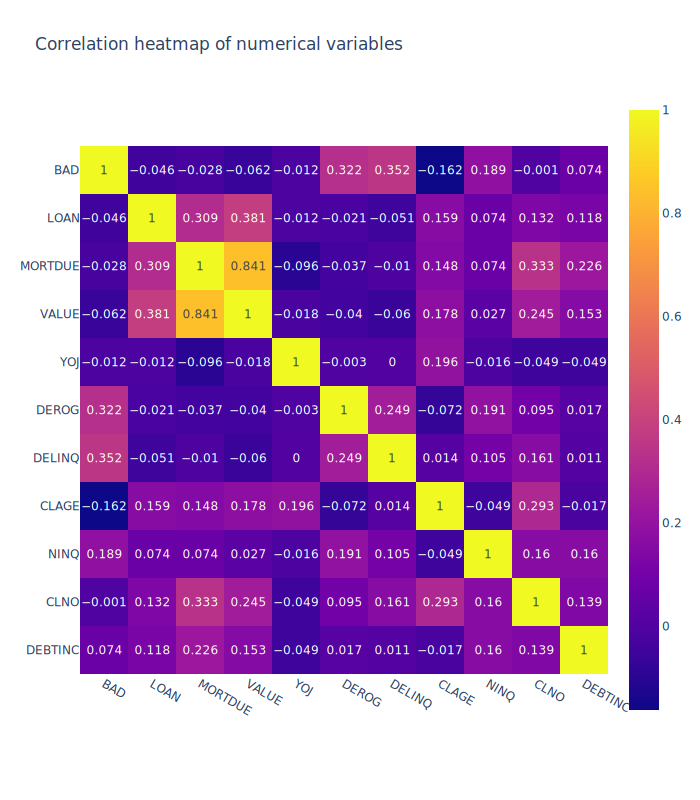

In [24]:
px.imshow(round(loan.corr(),3), 
          text_auto=True, height=800, title='Correlation heatmap of numerical variables')

#### Observations
- The default status (BAD) is most strongly correlated with DEROG and DELINQ, highlighting the importance of credit history as a significant factor in assessing default risk.

- all in all, there are no strong correlations between loan status(BAD) and other financial indicators such as  property value, or years at the job, indicating that no single financial metric is a strong predictor of loan default on its own.

#### Normally distributed or not
-Let's find out the stats summary for these numerical variables to have a quick look at the numbers

In [25]:
def test_normality(data):
    normal_test_list = [
        ('LOAN', stats.normaltest(data['LOAN'])[1]),
        ('VALUE', stats.normaltest(data['VALUE'])[1]),
        ('MORTDUE', stats.normaltest(data['MORTDUE'])[1]),
        ('YOJ', stats.normaltest(data['YOJ'])[1]),
        ('CLAGE', stats.normaltest(data['CLAGE'])[1]),
        ('DEROG', stats.normaltest(data['DEROG'])[1]),
        ('DELINQ', stats.normaltest(data['DELINQ'])[1]),
        ('NINQ', stats.normaltest(data['NINQ'])[1]),
        ('CLNO', stats.normaltest(data['CLNO'])[1]),
        ('DEBTINC', stats.normaltest(data['DEBTINC'])[1])
    ]
    # loop for name of the variable and whether or not it's normal
    for var, pval in normal_test_list:
        if pval <= 0.05:
            print(var, ": skewed")
        else:
            print(var, ": normal")
            
test_normality(loan)

LOAN : skewed
VALUE : skewed
MORTDUE : skewed
YOJ : skewed
CLAGE : skewed
DEROG : skewed
DELINQ : skewed
NINQ : skewed
CLNO : skewed
DEBTINC : skewed


#### Observations
- all numerical variables are skewed.

#### Average loan amount based on default status
- is the amount significantly different?

In [26]:
default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

np.round(default_loan.mean() - good_loan.mean())

-1119.0

#### Observation
- surprisingly, the average for defaulting loan amount is smaller than the good status loans by 1120 USD

#### Hypothesis Test 
- Due to the skewed distribution of the 'LOAN' variable, I'll utilize bootstrap sampling to determine if there is a statistically significant difference between the average loan amounts of good and defaulting clients.

#### State the Hypotheses:
- NULL(H 0): Good status and defaulting loan clients have the same average loan amount.
- Alternative(H 1): Good status and defaulting loan clients have different average loan amount.

In [27]:
# Separate your data into two groups for comparison
default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

# Define the number of bootstrap iterations
n_iterations = 1000 

# Define the sample size for bootstrap samples (typically the size of each group)
size_default = len(default_loan)
size_good = len(good_loan)

# Initialize arrays to store bootstrap sample means for each group
default_mean = np.zeros(n_iterations)
good_mean = np.zeros(n_iterations)

# Observed difference in means
observed_diff = round(default_loan.mean() - good_loan.mean())

# Generate bootstrap samples and compute means for each iteration
for i in range(n_iterations):
    default_sample = np.random.choice(default_loan, size=size_default, replace=True)
    good_sample = np.random.choice(good_loan, size=size_good, replace=True)
    default_mean[i] = default_sample.mean()
    good_mean[i] = good_sample.mean()

# Calculate the differences in means from the bootstrap samples
diff_means = default_mean - good_mean

# Calculate the p-value for hypothesis testing
p_value = np.sum(diff_means >= observed_diff) / n_iterations

# Print the observed difference and the p-value
print("Observed difference in means:", observed_diff)
print("P-value:", p_value)
# Define alpha
alpha = 0.05

if p_value <= alpha:
    print('There is a difference in the average loan of defaulting and good clients')
else:
    print('Not enough evidence to reject the null')

Observed difference in means: -1119
P-value: 0.501
Not enough evidence to reject the null


#### Observation
- so there isn't really a difference between the loan amounts, so loan amounts aren't a contributing factor in determining if a client will default or not

#### What is the most common category in the JOB variable?

In [38]:
loan['JOB'].value_counts()

ProfExe    1252
Office      921
Mgr         746
Self        188
Sales       109
Name: JOB, dtype: int64

#### Observation
- Professional executive isn't very descriptive while sales probably means sales-professional either doing B2C or B2B, but that isn't clear either

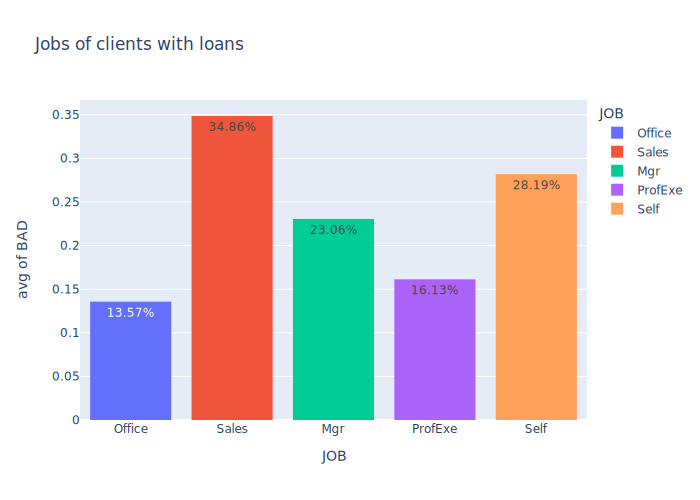

In [109]:
# Let's see what average defaulting % based on job
px.histogram(loan, y='BAD',x='JOB', histfunc='avg',color='JOB',
             title='Jobs of clients with loans',text_auto='.2%')

#### Observation
- These % represent the percentage of people within those jobs that defaulted
- Sales-related profession clients are most likely to default on their loans at more than 1/3 whereas Office-related clients are the least likely
-Sales, Manager, and Self-employed are all more than 1/5 meaning these are the most risky loan clients 

#### Reasons for loan
- Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?

In [64]:
# Create a contingency table to see the crosstab count
from scipy.stats import chi2_contingency
reason_status_cont = pd.crosstab(loan['Status'], loan['REASON'])

reason_status_cont

REASON,DebtCon,HomeImp
Status,,
Default,403,187
Good,1806,820


Let's answer question with a chi-squared hypothesis test: 

State the hypothesis:
* $H_0:$ There is no relationship between the two Reasons and loan status.  
* $H_1:$ There is a statistically significant relationship between between the reasons for taking out a loan and whethere or not the loan will be paid off

In [31]:
status_reason = chi2_contingency(reason_status_cont)[1]
alpha = 0.05
if status_reason <= 0.05:
    print('Evidence to reject the null hypothesis, there is a relationship between the two variables')
else:
    print('Evidence is insufficient to reject the null, there is no significant relationship')

Evidence is insufficient to reject the null, there is no significant relationship


#### Observation
- based on the cross-tab, the ratio of GL to DL is roughly the same at 4.5:1 for Debt consolidation, and 4.4:1 for home-improvement
- compared to all categories, an overwhelming people took out a loan for debt consolidation and paid it off
- as shown by the hypothesis test, there is no significant relationship between reason for loan and defaulting 

#### Derogatory reports vs. status
- is there a significant difference in GL and DL's derogatory reports?

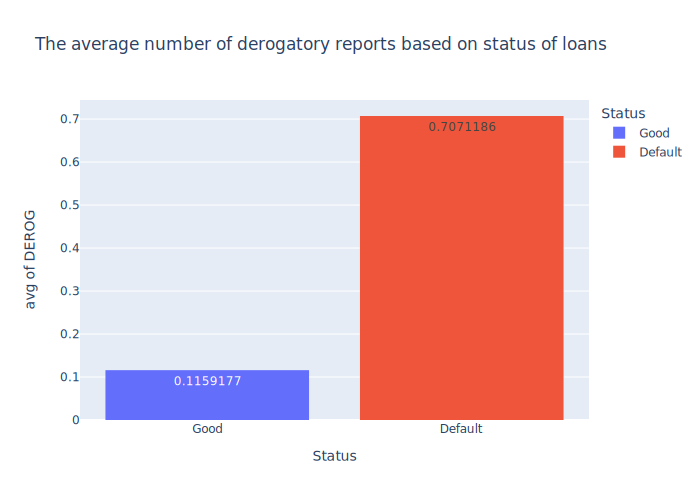

In [95]:
px.histogram(loan, x='Status', y='DEROG',
             color='Status', 
             histfunc='avg', 
             text_auto=True, title=
             'The average number of derogatory reports based on status of loans')

**Observations**
- quite an overwhelming difference in the average of GL at 0.08 and DL at 0.7 but the number is still less than 1.0
- it seems that the number of derogatory reports would be one of the strongest indicators of liklihood of defaulting loans

#### Logistic regression model and hypothesis test for DEROG vs. BAD

In [82]:
# first a logistic regression model for numerical binary class of GOOD and DEFAULT loans
X = sm.add_constant(loan['DEROG'])
y = loan['BAD']
model = sm.Logit(y, X).fit()
print(model.params)

Optimization terminated successfully.
         Current function value: 0.434124
         Iterations 6
const   -1.805019
DEROG    1.070546
dtype: float64


In [101]:
# Find the odds-ratio of the coefficient so that we can make sense of it
derog_coefficient = model.params[1] #the DEROG coefficient from the logistic regression
# Calculating the odds ratio
round(np.exp(derog_coefficient),2)


2.92

#### Observation
- For every 1 unit increase in a derogatory report, the chances of defaulting increase by 2.92 or in pretty much 3x 

#### Hypothesis Test:
- **Null $H_0$:** DEROG is not a significant predictor of default status (BAD).
- **Alternative $H_1$:** DEROG is a significant predictor of default status (BAD).

- If the p-value is less than $alpha$ (e.g., 0.05), we reject the null hypothesis, indicating that DEROG is a significant indicator of default status.

In [86]:
if model.pvalues[1] <= alpha:
    print("Sufficient evidence to reject the null")
else:
    print("Insufficient evidence to reject the NULL")

Sufficient evidence to reject the null


#### Observation
- As shown by the logistic regression and now by this hypothesis test that Derogatory reports are a significant indicator of liklihood defaulting loans 

#### Visualizing debt to income ratio vs. Delinquent credit lines

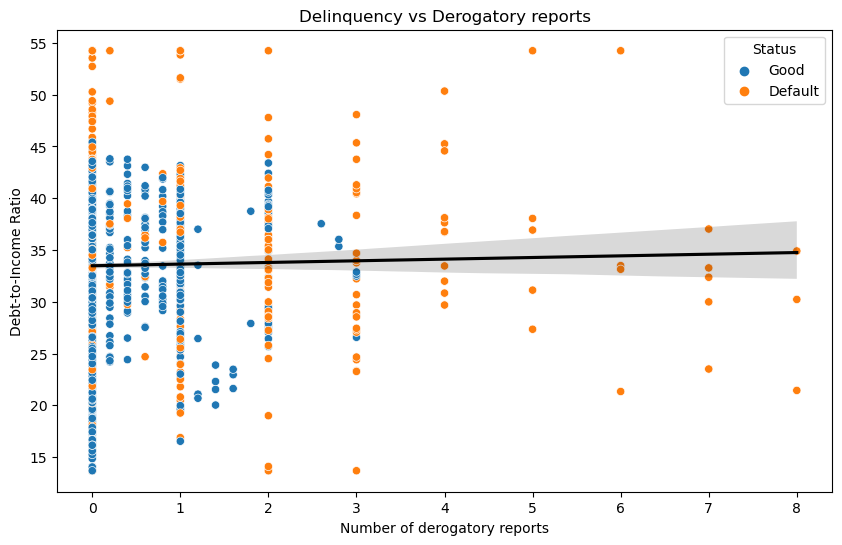

In [93]:
# Plotting the actual data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=loan, x='DEROG', y='DEBTINC', hue='Status')

sns.regplot(data=loan, x='DEROG', y='DEBTINC', scatter=False, color='black')
plt.title('Delinquency vs Derogatory reports')
plt.xlabel('Number of derogatory reports')
plt.ylabel('Debt-to-Income Ratio')
plt.show()

#### Observation
- the line of best is almost straight indicating almost no relationship, 
- clearly we can see that while there is no linear relationship, the defaulting loans have the higher DEBTINC as well as the higher DEROG while good status clients are concentrated in the opposite corner of lowest of both variables 

## Conclusion
##### Credit History Significance over job or loan-reason: 
- A client's credit-related variableas, including derogatory reports and delinquent credit lines, are a more significant predictor of loan defaults than the loan amount or job or reason for loan
##### Financial Metrics and Defaults: 
- The usual financial metrics like loan amount and property value don't strongly correlate with default rates
## Recommendations for future analysis
##### granularity:
- A more detailed dataset comprising more categories for jobs, and more specific loan reasons
- any information relating to income(if legal) could provide further insights since the Debt-to-income ratio was known meaning total income is known
- Additional data points, such as credit-score with a time-stamp giving the date and time at which it was known could enhance the understanding of default risks.